In [1]:
import sqlite3
import shapely
import numpy as np
import pandas as pd
import geopandas as gpd

# connect to database
conn = sqlite3.connect('/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/imagery/imagery.db')
# get grid data
grid_data = pd.read_sql_query("SELECT * FROM GridCells WHERE Internal=1", conn)
# get grid geometries
grid_geoms = gpd.read_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/imagery/grid_cells.feather")
# merge data
grid_data = gpd.GeoDataFrame(grid_data.merge(grid_geoms, on = "CellID"))
# close connection
conn.close()

i = 525

rivers = gpd.read_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/misc/msc_rivers.feather")
rivers_subset = gpd.clip(rivers.to_crs(5641), grid_data.geometry.iloc[i])

In [6]:
rivers["length"] = rivers.length
rivers.sort_values("length", ascending = False, inplace = True)

/scratch/slurm_tmpdir/job_23213442/ipykernel_26566/2942786478.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  rivers["length"] = rivers.length


In [ ]:
test = rivers[(rivers.NORIOCOMP != "Linha de Costa")].simplify(.0001)
test.plot(lw = .1)

---

In [ ]:
# - Explode MultiLineString to LineString
# - Update vertices, nodes
# - Get 
#  - Get indices of coordinates that are node
#  - Get those that are not at end of line
#  - Break line at those indices

In [28]:
class river_network:
    def __init__(self, shapefile):
        self.shapefile = shapefile
        self.vertices = None
        self.vertices_fl = None
        self.points = None
        self.points_indices = None
        self.ends = None
        self.ends_indices = None
        
    def explode_rivers(self):
        self.shapefile = self.shapefile.explode(index_parts=True)
        #self.shapefile.index = self.shapefile.index.map(lambda x: x[0] * 100 + x[1])
        
    def update_vertices(self):
        # get vertices as numpy array of line coordinates
        self.vertices = self.shapefile.geometry.map(lambda x: np.array(x.coords))
        # get first and last vertex of each line
        self.vertices_fl = self.shapefile.geometry.map(lambda x: np.array(x.coords)[[0,-1]])
        # get indices of flat list of vertices
        self.points_indices = np.repeat(self.vertices.index, self.vertices.map(len))
        # flatten vertices
        self.points = np.vstack(self.vertices)
        
    def update_nodes(self):
        # get unique points and their counts
        points_counts = np.unique(self.points, return_counts = True, axis = 0)
        # get nodes (points with more than one occurrence)
        self.nodes = points_counts[0][points_counts[1] > 1]
    
    def update_ends(self):
        # get unique points and their counts
        points_counts = np.unique(self.points, return_counts = True, axis = 0)
        # get those that only appear once
        points_ends = points_counts[0][points_counts[1] == 1]
        ## Get indices of single occurrence points as end candidates
        points_ends_reshaped = points_ends[:, np.newaxis, :]
        points_reshaped = self.points.reshape(1, self.points.shape[0], 2)
        points_ends_indices = np.where(np.all(points_reshaped == points_ends_reshaped, axis=2))
        ## Get end candidates that are at end of their respective line
        points_ends_reshaped = self.points[points_ends_indices[1]][:, np.newaxis, :]
        vertices_fl_subset = np.stack(self.vertices_fl.loc[self.points_indices[points_ends_indices[1]]])
        node_external_boolean = np.any(np.all(points_ends_reshaped == vertices_fl_subset, axis=2), axis=1)
        # get ends (points with exactly one occurrence at end of line)
        self.ends = self.points[points_ends_indices[1][node_external_boolean]]
        # get indices of ends
        self.ends_indices = points_ends_indices[1][node_external_boolean]
        
    def break_lines_at_nodes(self):
        ## Get indices of points that are node
        nodes_reshaped = self.nodes.reshape(self.nodes.shape[0], 1, 2)
        points_reshaped = self.points.reshape(1, self.points.shape[0], 2)
        # Get indices of matches between nodes and vertices,
        # (nodes_indices, points_indices) = np.where(matches)
        points_nodes_indices = np.where(np.all(nodes_reshaped == points_reshaped, axis=2))
        
        ## Get those that are not at end of its respective line
        points_nodes_reshaped = self.points[points_nodes_indices[1]][:, np.newaxis, :]
        vertices_fl_subset = np.stack(self.vertices_fl.loc[self.points_indices[points_nodes_indices[1]]])
        node_internal_boolean = np.logical_not(np.any(np.all(points_nodes_reshaped == vertices_fl_subset, axis=2), axis=1))
        
        ## Break lines where internal points are nodes
        for l in range(sum(node_internal_boolean)):
            # get index of vertex to split
            cindex = self.points_indices[points_nodes_indices[1][node_internal_boolean]][l]
            # get node to split at
            cnode = np.array([self.points[points_nodes_indices[1][node_internal_boolean]][l]])
            if type(self.shapefile.loc[cindex].geometry) == shapely.geometry.linestring.LineString:
                # get coordinates of river
                ccoords = np.array(self.shapefile.loc[cindex].geometry.coords)
                # get index of node in river
                isplit = np.where(np.all(ccoords == cnode, axis = 1))[0][0]
                # split river geometry
                #if (isplit == 1):
                #    rivers_subset.loc[cindex]["geometry"] = shapely.geometry.MultiLineString([shapely.geometry.LineString(ccoords[:(isplit+1)]), shapely.geometry.LineString(ccoords[(isplit):])])
                #else:   
                self.shapefile.loc[cindex, "geometry"] = shapely.geometry.MultiLineString([shapely.geometry.LineString(ccoords[:isplit+1]), shapely.geometry.LineString(ccoords[(isplit):])])
            if type(self.shapefile.loc[cindex].geometry) == shapely.geometry.multilinestring.MultiLineString:
                # get coordinates of sub-LineStrings in river
                ccoords = [np.array(x.coords) for x in self.shapefile.loc[cindex].geometry.geoms]
                # get index of sub-LineString to split
                iisplit = np.where([np.any(np.all(cnode == cccoords, axis = 1)) for cccoords in ccoords])[0][0]
                # get index of node in sub-LineString
                isplit = np.where(np.all(ccoords[iisplit] == cnode, axis = 1))[0][0]
                # skip if node is at end of sub-LineString
                if (isplit == 0 or isplit == len(ccoords[iisplit]) - 1):
                    continue
                # split river geometry
                ccoords = ccoords[:iisplit] + [ccoords[iisplit][:isplit+1]] + [ccoords[iisplit][isplit:]] + ccoords[iisplit+1:]
                self.shapefile.loc[cindex, "geometry"] = shapely.geometry.MultiLineString([shapely.geometry.LineString(x) for x in ccoords])

In [ ]:
# TODO: Implement split at border
# TODO: Implement indexing from seashore

In [34]:
boundaries = gpd.read_file("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/misc/raw/gadm/gadm41_BRA_2.json", engine = "pyogrio")
boundaries_subset = gpd.clip(boundaries.to_crs(5641), grid_data.geometry.iloc[i])

In [29]:
subset = river_network(rivers_subset)
subset.explode_rivers()
subset.update_vertices()
subset.update_nodes()
subset.break_lines_at_nodes()
subset.explode_rivers()
subset.update_vertices()
subset.update_nodes()
subset.update_ends()

In [23]:
subset.shapefile.loc[44522]

NORIOCOMP    CORIO                                           geometry
0 0  Rio Xapuri  49268_0  LINESTRING (2151375.000 8818486.592, 2151865.7...
  1  Rio Xapuri  49268_0  LINESTRING (2158844.531 8816020.542, 2158867.0...

In [17]:
nodes_counts = np.unique(subset.points, return_counts = True, axis = 0)

<Axes: >

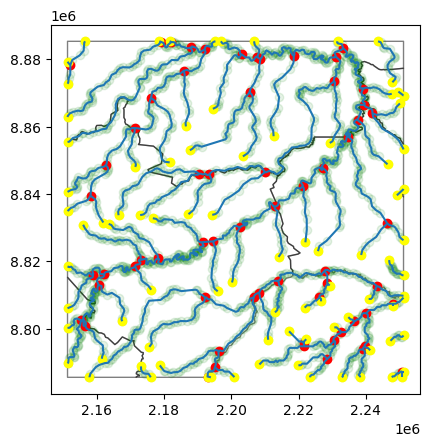

In [40]:
ax = rivers_subset.plot()
boundaries_subset.plot(ax = ax, edgecolor = "black", color = "None", alpha = .5)
gpd.GeoSeries([shapely.geometry.Point(x) for x in nodes_counts[0][nodes_counts[1] == 1]]).plot(ax = ax, color = "green", alpha = .1)
#gpd.GeoSeries([shapely.geometry.Point(x) for x in nodes_counts[0][nodes_counts[1] == 2]]).plot(ax = ax, color = "purple")
gpd.GeoSeries([shapely.geometry.Point(x) for x in nodes_counts[0][nodes_counts[1] > 2]]).plot(ax = ax, color = "red")
gpd.GeoSeries([shapely.geometry.Point(x) for x in subset.ends]).plot(ax = ax, color = "yellow")

In [ ]:
# Target: network of rivers only interrupted by nodes at merger points and adm2 borders
# Index increasing from shoreline up river (mouth, tributary, id), maybe implement tributary id by name?
# In parallel, write hierarchy of tributaries for cumulative sum

In [2]:
import ctypes
import numpy as np

j = 23

# Load the shared library
lib = ctypes.CDLL('/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/code/analysis/deforestation_extract.so')

# Define the argument and return types for the function
lib.calculatePolygons.argtypes = [
    ctypes.POINTER(ctypes.c_double), 
    ctypes.POINTER(ctypes.c_double), 
    ctypes.c_int, 
    ctypes.c_double, 
    ctypes.POINTER(ctypes.POINTER(ctypes.c_double)), 
    ctypes.POINTER(ctypes.POINTER(ctypes.c_double))
]
lib.calculatePolygons.restype = None

# Define the input data
X, Y = np.array(rivers_subset.geometry.iloc[j].coords.xy, dtype = np.double)
distance = 1000
N = len(X)

# Call the C++ function
polygonsX_ptr = ctypes.POINTER(ctypes.c_double)()
polygonsY_ptr = ctypes.POINTER(ctypes.c_double)()
lib.calculatePolygons(
    X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)), 
    Y.ctypes.data_as(ctypes.POINTER(ctypes.c_double)), 
    N, 
    distance, 
    ctypes.byref(polygonsX_ptr), 
    ctypes.byref(polygonsY_ptr)
)

# Convert the output to numpy arrays
polygonsX = np.ctypeslib.as_array(polygonsX_ptr, shape=(N - 3, 6))
polygonsY = np.ctypeslib.as_array(polygonsY_ptr, shape=(N - 3, 6))

test = np.array([shapely.geometry.Polygon([(polygonsX[i][j], polygonsY[i][j]) for j in range(6)]) for i in range(N - 3)])

# Free the allocated memory
lib.free(polygonsX_ptr)
lib.free(polygonsY_ptr)

0

<Axes: >

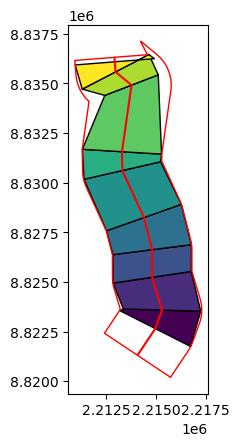

In [7]:
test_series = gpd.GeoSeries(test).reset_index()
ax = rivers_subset.iloc[[j]].plot(color = "red")
test_series.plot(ax = ax, edgecolor = "black", column = "index")
rivers_subset.iloc[[j]].buffer(2 * 1000, cap_style = "flat").plot(edgecolor = "red", color = "none", ax = ax)
